## week0_09 practice: PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will remind you how to use pytorch low and high-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

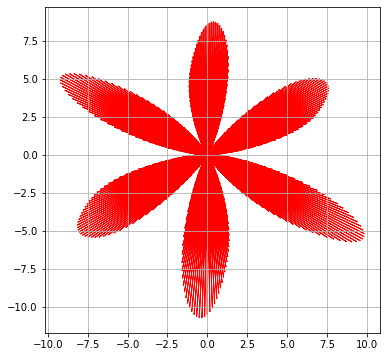

In [13]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(6 * theta))\
      * (1 + 0.01 * torch.cos(24 * theta))\
      * (0.5 + 0.05) * torch.cos(200 * theta)\
      * (10 + torch.sin(10 * theta))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = torch.sin(theta) * rho
y = torch.cos(theta) * rho


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color='red')
plt.grid()

### Task 2: Using the Dataloader

In [14]:
from torch import nn
from torch.nn import functional as F

In [15]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/basic_s20/week0_09_Optimization_and_Regularization_in_DL/notmnist.py -nc

File ‘notmnist.py’ already there; not retrieving.



In [16]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8259k  100 8259k    0     0  7739k      0  0:00:01  0:00:01 --:--:-- 7799k
x notMNIST_small/
x notMNIST_small/J/
x notMNIST_small/J/SHVtbnN0Nzc3IEJsa0NuIEJUIEJsYWNrLnR0Zg==.png
x notMNIST_small/J/SGFuZHdlcmsudHRm.png
x notMNIST_small/J/RW5ncmF2ZXItTGlnaHQgRXggQm9sZCBJdGFsaWMudHRm.png
x notMNIST_small/J/QnJpZGdld29ya0EudHRm.png
x notMNIST_small/J/QWFiY2VkIFJlZ3VsYXIudHRm.png
x notMNIST_small/J/RWlkZXRpY05lby1JdGFsaWMub3Rm.png
x notMNIST_small/J/Q2xhc3NpYyBUcmFzaCAxIEJSSy50dGY=.png
x notMNIST_small/J/SG9sbWVzMDAxLnR0Zg==.png
x notMNIST_small/J/Q29jb2EgVGhpbiBOb3JtYWwudHRm.png
x notMNIST_small/J/R2VvbWV0cjQxNSBNZCBCVCBNZWRpdW0udHRm.png
x notMNIST_small/J/Q29uc3RhbnRpYS50dGY=.png
x notMNIST_small/J/R290aGljNzIwIEJUIFJvbWFuLnR0Zg==.png
x notMNIST_small/J/RnV0dXJhIExpZ2h0IEl0YWxpYyBCVC50dGY=.png
x notMNIST_small/J/Q2VudHVyeTczMSBCVC

Extracting ...



x notMNIST_small/J/RnV0dXJhQlQtRXh0cmFCbGFja0NvbmRJdGFsaWMub3Rm.png
x notMNIST_small/J/QmFyY2xheSBPcGVuLnR0Zg==.png
x notMNIST_small/J/RHV0Y2ggODAxIEJvbGQgU1dBLnR0Zg==.png
x notMNIST_small/J/RGFpbHkgTmV3cyBCb2xkIEl0YWxpYy50dGY=.png
x notMNIST_small/J/Q2FzbG9uT2xkRmFjZUJULVJvbWFuLm90Zg==.png
x notMNIST_small/J/RnV0dXJhLUNvbmRlbnNlZExpZ2h0LVRoaW4udHRm.png
x notMNIST_small/J/QklHQ1NIQUQgTGVmdHkudHRm.png
x notMNIST_small/J/QUdPbGRGYWNlQlEtQm9sZE91dGxpbmUub3Rm.png
x notMNIST_small/J/R2FyYW1vbmRQcmVtclByby1NZWRJdERpc3Aub3Rm.png
x notMNIST_small/J/RXNwcml0RUYtTWVkaXVtSXRhbGljLm90Zg==.png
x notMNIST_small/J/QXV0bzEtSXRhbGljTEYudHRm.png
x notMNIST_small/J/QW50aXF1ZUFuY2llbm5lQ0UtSXRhbGljLm90Zg==.png
x notMNIST_small/J/Q29tcHV0ZXJmb250LnR0Zg==.png
x notMNIST_small/J/SG9tZW1hZGUgUm9ib3QgRXhwYW5kZWQudHRm.png
x notMNIST_small/J/QnJvZHkgUmVndWxhci50dGY=.png
x notMNIST_small/J/Q3Jvbm9zUHJvLUJvbGRTdWJoLm90Zg==.png
x notMNIST_small/J/RmxvcmlkYS1EZW1pQm9sZEl0YS5vdGY=.png
x notMNIST_small/J/RXhjYWxpYnVy

x notMNIST_small/J/RHJhZnRzbWFuIE5vcm1hbC50dGY=.png
x notMNIST_small/J/RGlzdHJpY3QtTGlnaHQudHRm.png
x notMNIST_small/J/QW1lcmljYW5Hb3RVUldUTWVkIEl0YWxpYy50dGY=.png
x notMNIST_small/J/Q1FOLU1vbGVjdWxhci1EeW5hbW8tUmVndWxhci5vdGY=.png
x notMNIST_small/J/R2FycmljayBFeHRlbmRlZCBOb3JtYWwudHRm.png
x notMNIST_small/J/R2lsbCBTYW5zIE1UIEV4dHJhIEJvbGQudHRm.png
x notMNIST_small/J/QnJlbGEtVGhpbi50dGY=.png
x notMNIST_small/J/QmFydCBUaGluIEJvbGRJdGFsaWMudHRm.png
x notMNIST_small/J/Q29sb3NzYWxpcy1CbGFjay5vdGY=.png
x notMNIST_small/J/QmV0YSBCbG9jay50dGY=.png
x notMNIST_small/J/QW5kYWxlTW9ub01UU3RkLUJvbGQub3Rm.png
x notMNIST_small/J/RnV0dXJhTFQtQm9va09ibGlxdWUub3Rm.png
x notMNIST_small/J/R2luZ2VyLUxpZ2h0SXRhbGljLm90Zg==.png
x notMNIST_small/J/SWJhbGxhbnRpbmVzLUJvbGQub3Rm.png
x notMNIST_small/J/QWxlbWJpY0JldGEtUmVndWxhclR3by5vdGY=.png
x notMNIST_small/J/R2luZ2VyLVJlZ3VsYXJJdGFsaWNFeHBlcnQub3Rm.png
x notMNIST_small/J/QWVvc0xpZ2F0dXJlLm90Zg==.png
x notMNIST_small/J/QW1UeXBld3JpdGVyRUYtTGlnaHQub3Rm.png
x no

x notMNIST_small/E/QmVydHJhbS50dGY=.png
x notMNIST_small/E/Qm9uayBPdXRlcmN1dC50dGY=.png
x notMNIST_small/E/RnV0dXJhIElDRyBYQm9sZCBPYmxpcXVlLnR0Zg==.png
x notMNIST_small/E/SGVybWFubiBJdGFsaWMudHRm.png
x notMNIST_small/E/RWRkaWVzSGFuZCBSZWd1bGFyLnR0Zg==.png
x notMNIST_small/E/RkZGIEludGVyZmFjZTA2Yi50dGY=.png
x notMNIST_small/E/Q2FzdG9yZ2F0ZSAtIFJvdWdoLnR0Zg==.png
x notMNIST_small/E/QmFzcXVlIFRoaW4gTm9ybWFsLnR0Zg==.png
x notMNIST_small/E/RWxlY3RyaWMgR29hdC50dGY=.png
x notMNIST_small/E/QmFpbGV5IFNhbnMgSVRDIEJvb2sudHRm.png
x notMNIST_small/E/Qm9yem9pIE1lZGl1bS50dGY=.png
x notMNIST_small/E/Q2VudHVyeVNjaG9vbC5vdGY=.png
x notMNIST_small/E/QUxFWDIub3Rm.png
x notMNIST_small/E/SHVtYnVja2VyIE5hc3R5LnR0Zg==.png
x notMNIST_small/E/RnVqaSBUaGluIEl0YWxpYy50dGY=.png
x notMNIST_small/E/QXJub3ZhSVRDIFRULnR0Zg==.png
x notMNIST_small/E/RnV0dXJhSUNHLUJvbGQub3Rm.png
x notMNIST_small/E/Qm91Z2FuIFNTaSBTZW1pIEJvbGQudHRm.png
x notMNIST_small/E/RHluYW1vRHhjRFhDLm90Zg==.png
x notMNIST_small/E/RGF2aWxsZSBDb25kZW5zZ

x notMNIST_small/E/SGl2ZS1Vbml0Lm90Zg==.png
x notMNIST_small/E/RFRMRmxlaXNjaG1hbm4tRFJlZ3VsYXIub3Rm.png
x notMNIST_small/E/RDMgUm9hZHN0ZXJpc20gTG9uZy50dGY=.png
x notMNIST_small/E/QW1wbGlmaWVyTGlnaHRTbWFsbENhcHMub3Rm.png
x notMNIST_small/E/QW50aXF1YSAxMDEgQ29uZGVuc2VkIEl0YWxpYy50dGY=.png
x notMNIST_small/E/SGFsbG1hcmtlIEJvbGQgSXRhbGljLnR0Zg==.png
x notMNIST_small/E/QnVsbWVyLUl0bC5vdGY=.png
x notMNIST_small/E/Qmlja2hhbSBTY3JpcHQgVHdvLnR0Zg==.png
x notMNIST_small/E/Q29wcGVycGxhdGUgRXh0cmEgQ29uZGVuc2VkIFNTaSBCb2xkIEV4dHJhIENvbmRlbnNlZC50dGY=.png
x notMNIST_small/E/QmVsdWNpYW4tRGVtaUJvbGQub3Rm.png
x notMNIST_small/E/QXN0cm9uIEJveSBWaWRlby50dGY=.png
x notMNIST_small/E/Q2hlcmllIElUQy50dGY=.png
x notMNIST_small/E/RGlsbGVuaWFVUEMgSXRhbGljLnR0Zg==.png
x notMNIST_small/E/R2lsbFNhbnNNVFN0ZC1IZWF2eS5vdGY=.png
x notMNIST_small/E/RmF2b3JpdC50dGY=.png
x notMNIST_small/E/R2FyYW1vbmRIYW5kdEVGLUJvbGQub3Rm.png
x notMNIST_small/E/SGVpZGVsYmVyZy50dGY=.png
x notMNIST_small/E/Q2hyb21lWWVsbG93LnR0Zg==.png
x no

x notMNIST_small/I/QWdlbmRhdHlwZS1SZWd1bGFyLm90Zg==.png
x notMNIST_small/I/QXBwbGUgR2FyYW1vbmQgQm9vayBCVC50dGY=.png
x notMNIST_small/I/R291ZHlDYXRhbG9ndWVCVC1SZWd1bGFyLm90Zg==.png
x notMNIST_small/I/RHluYW1vUmVIRS5vdGY=.png
x notMNIST_small/I/RnV0dXJpc0V4dHJhIEN5cmlsbGljQC50dGY=.png
x notMNIST_small/I/RGV2aWwgRG9nIEJUTi50dGY=.png
x notMNIST_small/I/R2lsbFNhbnMtQ29uZGVuc2VkLm90Zg==.png
x notMNIST_small/I/Q2hpbGFkYUlDRy1Vbm8ub3Rm.png
x notMNIST_small/I/Q2FzbG9uIENhbGxpZ3JhcGhpYyBJbml0aWFscy50dGY=.png
x notMNIST_small/I/RXVyb3N0aWxlVEJsYS50dGY=.png
x notMNIST_small/I/QmV0YVNlbWktQm9sZC5vdGY=.png
x notMNIST_small/I/MTJTYXJ1WWVsbG93Rm9nLnR0Zg==.png
x notMNIST_small/I/R2FzLm90Zg==.png
x notMNIST_small/I/QmVuZ3VpYXRDb25kZW5zZWRCUS1Cb29rSXRhbGljLm90Zg==.png
x notMNIST_small/I/Q3JvaXNzYW50RUYub3Rm.png
x notMNIST_small/I/SHVtYW5pc3Q3NzdCVC1FeHRyYUJsYWNrQi5vdGY=.png
x notMNIST_small/I/SG9ycmVuZG91cy50dGY=.png
x notMNIST_small/I/RGFsbGlhbmNlRmxvdXJpc2hlcy5vdGY=.png
x notMNIST_small/I/QmxhY2tCZWFyZ

x notMNIST_small/I/RmVuaWNlLVVsdHJhLm90Zg==.png
x notMNIST_small/I/RnJhbmNpcy5vdGY=.png
x notMNIST_small/I/QmxhY2thZGRlciBJVEMgVFQudHRm.png
x notMNIST_small/I/RHJhZ29uRUYtRGVtaUJvbGQub3Rm.png
x notMNIST_small/I/RmlnaHQgVGhpcy50dGY=.png
x notMNIST_small/I/R2lsbFNhbnNNVFN0ZC1Cb2xkLm90Zg==.png
x notMNIST_small/I/QmVhbSBSaWRlciBFeHBhbmRlZC50dGY=.png
x notMNIST_small/I/Q2xlb3BhdHJhLm90Zg==.png
x notMNIST_small/I/RWxlZ2FHYXJtbmQgQlQgSXRhbGljLnR0Zg==.png
x notMNIST_small/I/R2VvbWV0cjIxMiBCayBCVCBCb29rLnR0Zg==.png
x notMNIST_small/I/Q2VudHVyeSBTY2hvb2xib29rIEl0YWxpYy5wZmI=.png
x notMNIST_small/I/SGlnaHN0YWtlcyBSZWd1bGFyLnR0Zg==.png
x notMNIST_small/I/Q29tcHJlc3Nvci1TbGFiU2VyaWYub3Rm.png
x notMNIST_small/I/RWxHYXIgQm9sZC50dGY=.png
x notMNIST_small/I/Q2xpcXVlLVNlcmlmQm9sZE9ibGlxdWUub3Rm.png
x notMNIST_small/I/QmVsbGFteUV4dHJhQm9sZC5vdGY=.png
x notMNIST_small/I/QW5hbGdlc2ljcy50dGY=.png
x notMNIST_small/I/RnJhbmtlbkRvcmsgVGFsbC50dGY=.png
x notMNIST_small/I/RWxsaW5ndG9uTVQtQm9sZEl0YWxpYy5vdGY=.png


x notMNIST_small/I/RWtsZWt0aWMtTm9ybWFsLUxpZ2h0LnR0Zg==.png
x notMNIST_small/I/RGF2eXMtUmliYm9ucyBSZWd1bGFyLnR0Zg==.png
x notMNIST_small/I/QXJ0aXN0YS50dGY=.png
x notMNIST_small/I/Q29yZGlhIE5ldyBCb2xkIEl0YWxpYy50dGY=.png
x notMNIST_small/I/R3JhZmlsb25lTExMaWdodC50dGY=.png
x notMNIST_small/I/QW5kZXJzb24ub3Rm.png
x notMNIST_small/I/Rml0enJveSBJdGFsaWMudHRm.png
x notMNIST_small/I/RnJ1dGlnZXJOZXh0TFQtTGlnaHRJdGFsaWMub3Rm.png
x notMNIST_small/I/RGF2aWRhRUYub3Rm.png
x notMNIST_small/I/RXdpbmdzSGFuZCBSZWd1bGFyLnR0Zg==.png
x notMNIST_small/I/R2lhY29tbyBMaWdodCBJdGFsaWMub3Rm.png
x notMNIST_small/I/RXJhcyBCb29rIEJULnR0Zg==.png
x notMNIST_small/I/RWlkZXRpY05lby1Cb2xkLm90Zg==.png
x notMNIST_small/I/R3JvdGVzcXVlTVRTdGQtTGlnaHRJdGFsaWMub3Rm.png
x notMNIST_small/I/QW1lcmljYW5hLUJvbGQub3Rm.png
x notMNIST_small/I/RnJhbmtsaW5Hb3RoaWMtTWVkQ25kLm90Zg==.png
x notMNIST_small/I/RWRpc29uRUYtQm9vay5vdGY=.png
x notMNIST_small/I/QmlvbmljIENvbWljIEV4cCBJdGFsaWMudHRm.png
x notMNIST_small/I/QXJrb25hIFJlZ3VsYXIucGZi.

x notMNIST_small/A/Q2FzbG9uIEJvb2sgQkUgQm9sZC50dGY=.png
x notMNIST_small/A/Q2hlbHRlbmhhbVN0ZC1Cb2xkLm90Zg==.png
x notMNIST_small/A/Rm9saW9CVC1MaWdodEl0YWxpYy5vdGY=.png
x notMNIST_small/A/SGVsdmV0aWNhQlEtQmxhY2tJdGFsaWMub3Rm.png
x notMNIST_small/A/QnJ1aXNlZCBUd2VudHlGaXZlLnR0Zg==.png
x notMNIST_small/A/RmxldGNoIFdpZGUgQm9sZEl0YWxpYy50dGY=.png
x notMNIST_small/A/QWxwaGFiZXRTb3VwQlQtVGlsdC5vdGY=.png
x notMNIST_small/A/R2FyYW1vbmQtTm9ybWFsIEJvbGQgSXRhbGljLnR0Zg==.png
x notMNIST_small/A/RmxhdCBCcnVzaCBUaGluIE5vcm1hbC50dGY=.png
x notMNIST_small/A/QmVybmhhcmQgTW9kZXJuIEJvbGQgSXRhbGljIEJULnR0Zg==.png
x notMNIST_small/A/SGFyZFRpbWVzUmVndWxhci5vdGY=.png
x notMNIST_small/A/SGVsdmV0aWNhLU5hcnJvdy1Cb2xkLm90Zg==.png
x notMNIST_small/A/QnJvY2h1cmUudHRm.png
x notMNIST_small/A/RnJhbmtmdXJ0R290aGljIEJvbGQudHRm.png
x notMNIST_small/A/RWR3YXJkRWR3aW4gQm9sZC50dGY=.png
x notMNIST_small/A/Q2VudHVyeSA3NTEgQm9sZCBJdGFsaWMucGZi.png
x notMNIST_small/A/R2Fycmlzb24gU2FucyBJVEFMSUMudHRm.png
x notMNIST_small/A/RG9nb

x notMNIST_small/A/SG9iYnkgV2lkZSBOb3JtYWwudHRm.png
x notMNIST_small/A/RHluYW1vUnhlSXRhbGljSFhFLm90Zg==.png
x notMNIST_small/A/SGFuIFNvbG8gRXhwYW5kZWQudHRm.png
x notMNIST_small/A/MDEtMDEtMDAudHRm.png
x notMNIST_small/A/SGFsbG93ZWVuIE1hdGNoLnR0Zg==.png
x notMNIST_small/A/QW1lcmljYW5UeXBld3JpdGVyLUxpZ2h0Q29uZEEub3Rm.png
x notMNIST_small/A/RXBpcGhvbi5vdGY=.png
x notMNIST_small/A/RmFnb0NvTGYub3Rm.png
x notMNIST_small/A/Qml0c3RyZWFtIEFtZXJpZ28gQm9sZCBJdGFsaWMucGZi.png
x notMNIST_small/A/RGlzY28gRG9yayBJdGFsaWMudHRm.png
x notMNIST_small/A/Q2F2ZSBHeXJsLnR0Zg==.png
x notMNIST_small/A/RkZGIFN0YXIgQm9sZC50dGY=.png
x notMNIST_small/A/RXJhcyBJdGMgVCBFRSBMaWdodC5wZmI=.png
x notMNIST_small/A/Qml0c3RyZWFtIEFtZXJpZ28gQm9sZC5wZmI=.png
x notMNIST_small/A/RnV0dXJhIEJvbGQgQ29uZGVuc2VkIEl0YWxpYyBCVC50dGY=.png
x notMNIST_small/A/RHluYW1lIEJsYWNrIFNTaSBCb2xkLnR0Zg==.png
x notMNIST_small/A/RGV2ZW5kcmEgRXgudHRm.png
x notMNIST_small/A/Q2VudG8gRXh0ZW5kZWQgQm9sZEl0YWxpYy50dGY=.png
x notMNIST_small/A/RHJhZ29uLU1lZ

x notMNIST_small/G/Q2FzbG9uQzM3LUxndEl0bEFsdC5vdGY=.png
x notMNIST_small/G/QXN0cmlkIFNob3J0LnR0Zg==.png
x notMNIST_small/G/R3JvdmVyIEl0YWxpYy50dGY=.png
x notMNIST_small/G/R2FsbGVyeSBDb25kZW5zZWQgTm9ybWFsLnR0Zg==.png
x notMNIST_small/G/Q29wYSBTaGFycCBCVE4gU2hhZG93LnR0Zg==.png
x notMNIST_small/G/RnJhbmNpcyBIaWdoIExpZ2h0ZWQgQ29uZGVuc2VkIE5vcm1hbC50dGY=.png
x notMNIST_small/G/Q2hpc2VsIFdpZGUgSXRhbGljLnR0Zg==.png
x notMNIST_small/G/QWdlbmRhLUxpZ2h0Lm90Zg==.png
x notMNIST_small/G/RnVqaSBOb3JtYWwudHRm.png
x notMNIST_small/G/RFRMQXJnb1QtVWx0cmFIZWF2eUl0YWxpYy5vdGY=.png
x notMNIST_small/G/QmFja3RhbGtTZXJpZiBCVE4gU0MgQm9sZE9ibGlxdWUudHRm.png
x notMNIST_small/G/R290aGljNzIwIEJUIEJvbGQgSXRhbGljLnR0Zg==.png
x notMNIST_small/G/RnVubnkgUGFnZXMgU2hhZG93LnR0Zg==.png
x notMNIST_small/G/QnJhbmRvIEVuZ3JhdmVkIENvbmRlbnNlZCBCb2xkLnR0Zg==.png
x notMNIST_small/G/Q2VudHVyeSBTY2hvb2xib29rIEl0YWxpYyBCVC50dGY=.png
x notMNIST_small/G/Q2hhcnRlciBPU0YgQlQgQmxhY2sgSXRhbGljLnR0Zg==.png
x notMNIST_small/G/Q29uc3RydWN0Y

x notMNIST_small/G/RWxpY2l0U1NLIEJvbGQudHRm.png
x notMNIST_small/G/RmxhdCBCcnVzaCBJdGFsaWMudHRm.png
x notMNIST_small/G/R2Fpc2VyaWMgRGVtby50dGY=.png
x notMNIST_small/G/Q291cmllckMtT2JsaXF1ZS5vdGY=.png
x notMNIST_small/G/RW5nbGlzY2hlU2NoVCBCb2xkLnR0Zg==.png
x notMNIST_small/G/Qml0c3RyZWFtIFZlcmEgU2FucyBNb25vIE9ibGlxdWUudHRm.png
x notMNIST_small/G/Qm9kb25pQy1Cb2xkSXRhbGljLm90Zg==.png
x notMNIST_small/G/QWxkaW5lNzIxQlQtQm9sZENvbmRlbnNlZC5vdGY=.png
x notMNIST_small/G/QnVyYmFua0JpZ1dpZGUtTGlnaHQub3Rm.png
x notMNIST_small/G/QmVya2VsZXlPbGRzdHlsZUJvbGQub3Rm.png
x notMNIST_small/G/RWxla3Ryb24udHRm.png
x notMNIST_small/G/QnJhaW5oZWFkLnR0Zg==.png
x notMNIST_small/G/Q2VudHVyeUlUQ2J5QlQtQm9sZENvbmRJdGFsaWMub3Rm.png
x notMNIST_small/G/Qm9yZGVhdXggSXRhbGljIFBsYWluLnR0Zg==.png
x notMNIST_small/G/Q2VudHVyeTczMUJULUJvbGRJdGFsaWNBLm90Zg==.png
x notMNIST_small/G/Qm9kb25pU2V2SVRDLUJvb2tJdGFsLm90Zg==.png
x notMNIST_small/G/QnViYmFMb3ZlLUJvbGQub3Rm.png
x notMNIST_small/G/Q2VudHVyeSBHb3RoaWMudHRm.png
x notMNI

x notMNIST_small/G/R29ybG9jayAgQm9sZC50dGY=.png
x notMNIST_small/G/SVRDIFVzaGVyd29vZCBCbGFjayBJdGFsaWMucGZi.png
x notMNIST_small/G/QXJtYWRhLUJsYWNrQ29tcHJlc3NlZC5vdGY=.png
x notMNIST_small/G/R290aGFtIE5pZ2h0cyBOb3JtYWwudHRm.png
x notMNIST_small/G/QW1lcmljYW4gVHlwZXdyaXRlciBNZWRpdW0gQlQudHRm.png
x notMNIST_small/G/Q29tcGFjdEMtQm9sZEl0YWxpYy5vdGY=.png
x notMNIST_small/G/SGFjayAmIFNsYXNoIEJSSy50dGY=.png
x notMNIST_small/G/QmxhY2tsZXR0ZXIgSFBMSFMudHRm.png
x notMNIST_small/G/RGlkb3QtSFRGLU02NC1NZWRpdW0ub3Rm.png
x notMNIST_small/G/QW1pbnRhQm9sZC50dGY=.png
x notMNIST_small/G/QmF1ZXJCb2RvbmlCVC1CbGFjay5vdGY=.png
x notMNIST_small/G/R2FyYW1vbmQtVGhpbi1JdGFsaWMudHRm.png
x notMNIST_small/G/Q29uY29yZGVCRS1Cb2xkQ24ub3Rm.png
x notMNIST_small/G/QW1lcmljYW5UeXBld3JpdGVyQ29uQlEtQm9sZC5vdGY=.png
x notMNIST_small/G/RmFnb05vVGYtTWVkaXVtQ2Fwcy5vdGY=.png
x notMNIST_small/G/Q29sbWNpbGxlTVRTdGQtUmVndWxhci5vdGY=.png
x notMNIST_small/G/SHVtYW5pc3QgU2xhYnNlcmlmIDcxMi5wZmI=.png
x notMNIST_small/G/QW1wbGl0dWRlRXh0c

x notMNIST_small/F/Qm9kb25pQmVydGhvbGRCUS1Cb2xkSXRhbGljLm90Zg==.png
x notMNIST_small/F/SVRDIEdvdWR5IFNhbnMgTGlnaHQucGZi.png
x notMNIST_small/F/RmxhdCBCcnVzaCBUaGluIEJvbGRJdGFsaWMudHRm.png
x notMNIST_small/F/QW50aXF1ZU1vZGVybmUtUmVndWxhci5vdGY=.png
x notMNIST_small/F/QWRyZW5hbGluLm90Zg==.png
x notMNIST_small/F/Q2xlYXJmYWNlQVRGQlEtQm9sZC5vdGY=.png
x notMNIST_small/F/QW50aXF1ZU9saXZlLUl0YWxpYy5vdGY=.png
x notMNIST_small/F/Qm9kb25pRUYtTGlnaHQub3Rm.png
x notMNIST_small/F/RnV0dXJpc3RCbGFjayBJdGFsaWMudHRm.png
x notMNIST_small/F/QmVybGluZXJHcm90ZXNrLUxpZ2h0Lm90Zg==.png
x notMNIST_small/F/QnJpZW1TY3JpcHRTdGQtQm9sZC5vdGY=.png
x notMNIST_small/F/SHVtYW5hIFNjcmlwdCBJVEMgVFQgQm9sZC50dGY=.png
x notMNIST_small/F/Qmlqb3V4LUJvbGQub3Rm.png
x notMNIST_small/F/RWxsaW5ndG9uIE1UIEJvbGQudHRm.png
x notMNIST_small/F/RmF1eC1SZWd1bGFyLm90Zg==.png
x notMNIST_small/F/Q2FzbG9uIEJvb2sgQkUgQm9sZC50dGY=.png
x notMNIST_small/F/Q2hlbHRlbmhhbVN0ZC1Cb2xkLm90Zg==.png
x notMNIST_small/F/Rm9saW9CVC1MaWdodEl0YWxpYy5vdGY=.png


x notMNIST_small/F/RkZYIFRpbWVzIEVuZ3JhdmVkLnR0Zg==.png
x notMNIST_small/F/Qm9kb25pU2l4SVRDLUJvbGQub3Rm.png
x notMNIST_small/F/R29kZmF0aGVyLnR0Zg==.png
x notMNIST_small/F/Qm9kb25pQmF1ZXJCUS1SZWd1bGFyLm90Zg==.png
x notMNIST_small/F/RmxvcmluZGFJVENTdGQub3Rm.png
x notMNIST_small/F/SG9iYnkgV2lkZSBOb3JtYWwudHRm.png
x notMNIST_small/F/RHluYW1vUnhlSXRhbGljSFhFLm90Zg==.png
x notMNIST_small/F/SGFuIFNvbG8gRXhwYW5kZWQudHRm.png
x notMNIST_small/F/MDEtMDEtMDAudHRm.png
x notMNIST_small/F/SGFsbG93ZWVuIE1hdGNoLnR0Zg==.png
x notMNIST_small/F/QW1lcmljYW5UeXBld3JpdGVyLUxpZ2h0Q29uZEEub3Rm.png
x notMNIST_small/F/RXBpcGhvbi5vdGY=.png
x notMNIST_small/F/RmFnb0NvTGYub3Rm.png
x notMNIST_small/F/Qml0c3RyZWFtIEFtZXJpZ28gQm9sZCBJdGFsaWMucGZi.png
x notMNIST_small/F/RGlzY28gRG9yayBJdGFsaWMudHRm.png
x notMNIST_small/F/Q2F2ZSBHeXJsLnR0Zg==.png
x notMNIST_small/F/RkZGIFN0YXIgQm9sZC50dGY=.png
x notMNIST_small/F/RXJhcyBJdGMgVCBFRSBMaWdodC5wZmI=.png
x notMNIST_small/F/Qml0c3RyZWFtIEFtZXJpZ28gQm9sZC5wZmI=.png
x notMNIST_s

x notMNIST_small/B/R2FyYW1vbmRUaHJlZS1JdGFsaWNPc0Yub3Rm.png
x notMNIST_small/B/QWx0ZVNjaEQub3Rm.png
x notMNIST_small/B/Q2F4dG9uIExpZ2h0IEl0YWxpYyBCVC50dGY=.png
x notMNIST_small/B/QmFyY2Vsb25hSVRDU3RkLUJvb2tJdGFsaWMub3Rm.png
x notMNIST_small/B/RHVzdFBpZWNlLm90Zg==.png
x notMNIST_small/B/Qm9kb25pQkUtTWVkaXVtQ24ub3Rm.png
x notMNIST_small/B/R2VvbWV0cmljIDg4NS5wZmI=.png
x notMNIST_small/B/R2F6ei5vdGY=.png
x notMNIST_small/B/QWxiZXJ0YW5Cb2xkTC5vdGY=.png
x notMNIST_small/B/RWxla3RyaXhMaWdodC5vdGY=.png
x notMNIST_small/B/QmVuZ3VpYXRDb25kZW5zZWRCUS1NZWRpdW0ub3Rm.png
x notMNIST_small/B/RW5ncmF2ZXJzRC50dGY=.png
x notMNIST_small/B/QWxiYXRyb3NzLnR0Zg==.png
x notMNIST_small/B/RGFuY2luU3RkLm90Zg==.png
x notMNIST_small/B/QmlvbWVjaGFuaWMudHRm.png
x notMNIST_small/B/Rm9udFNvdXBDYXRhbGFuLVJlZ3VsYXIub3Rm.png
x notMNIST_small/B/Q29yb25ldC1TZW1pQm9sZC1JdGFsaWMgRXgudHRm.png
x notMNIST_small/B/RFRMQ2FzcGFyaVNULUJvbGQub3Rm.png
x notMNIST_small/B/QmF1aGF1c0l0Y1RFRUJvbC50dGY=.png
x notMNIST_small/B/QmlsYm9EaXNwb

x notMNIST_small/B/QnVsbWVyTVQtQm9sZERpc3BsYXkub3Rm.png
x notMNIST_small/B/RnV0dXJhQ29uZE1lZGl1bS5vdGY=.png
x notMNIST_small/B/QmFzZU5pbmUgQm9sZC50dGY=.png
x notMNIST_small/B/RmFnb05vVGYtQm9sZENhcHMub3Rm.png
x notMNIST_small/B/RkZGIFJlYWN0aW9uIEJvbGQgRXh0ZW5kZWQudHRm.png
x notMNIST_small/B/RHIgU3VnaXlhbWEudHRm.png
x notMNIST_small/B/QmxvY2tCRS1SZWd1bGFyLm90Zg==.png
x notMNIST_small/B/RXZvQlEtTWVkaXVtSXRhbGljLm90Zg==.png
x notMNIST_small/B/Q292aW5ndG9uIENvbmQgQm9sZCBJdGFsaWMudHRm.png
x notMNIST_small/B/Q2xpcGUgT3Blbi50dGY=.png
x notMNIST_small/B/QXF1aXRhaW5lIEluaXRpYWxzIElDRy50dGY=.png
x notMNIST_small/B/QnVyaW5TYW5zU3RkLm90Zg==.png
x notMNIST_small/B/Q29zdGFQdGYtRGVtaS5vdGY=.png
x notMNIST_small/B/Q2dGdXR1cmFNYXhpTHQudHRm.png
x notMNIST_small/B/R3Jla29EZWNvLnR0Zg==.png
x notMNIST_small/B/QXZhbnRHYXJkZUlUQ2J5QlQtRXh0cmFMaWdodE9ibC5vdGY=.png
x notMNIST_small/B/R291ZHkgT2xkIFN0eWxlIEJvbGQgQlQudHRm.png
x notMNIST_small/B/Q2hlc3RlcmZpZWxkQW50RC50dGY=.png
x notMNIST_small/B/RGVlcGRlbmVILm90Z

x notMNIST_small/B/Q291bnRyeXNpZGUgQmxhY2sgU1NpIEV4dHJhIEJvbGQudHRm.png
x notMNIST_small/B/Q29yYmVpIFVuY2lhbC50dGY=.png
x notMNIST_small/B/R2xhc3MgSG91c2VzLnR0Zg==.png
x notMNIST_small/B/RGFsZXlzR290aGljLUJsYWNrLm90Zg==.png
x notMNIST_small/B/QmVya2VsZXlPbGRzdHlsZUlUQ2J5QlQtTWVkSXRhbC5vdGY=.png
x notMNIST_small/B/RWxlcGhhbnQgRXh0ZW5kZWQgQm9sZC50dGY=.png
x notMNIST_small/B/RnV0dXJhVEVFLnR0Zg==.png
x notMNIST_small/B/SVRDIEFtZXJpY2FuIFR5cGV3cml0ZXIgQm9sZCBBbHRlcm5hdGUucGZi.png
x notMNIST_small/B/SGVsdmV0aWNhSW5zZXJhdEJRLVJlZ3VsYXIub3Rm.png
x notMNIST_small/B/QWlybGluZS1Ob3JtYWwub3Rm.png
x notMNIST_small/B/Qml0c3RyZWFtIFZlcmEgU2VyaWYgQm9sZC50dGY=.png
x notMNIST_small/B/QXVndXN0YUNhbmNlbGxhcmVzY2FTdGQtUmVnLm90Zg==.png
x notMNIST_small/B/RmVkZXJhdGlvbiBTdGFyZmxlZXQgMS50dGY=.png
x notMNIST_small/B/Qm90b25CUS1NZWRpdW1JdGFsaWMub3Rm.png
x notMNIST_small/B/Qmxhdmlja2UgQ2FwaXRhbHMgU2VtaS1leHBhbmRlZCBSZWd1bGFyLnR0Zg==.png
x notMNIST_small/B/Q2Fyb2xzQ2h1bmtzLnR0Zg==.png
x notMNIST_small/B/QmV0b25FR

x notMNIST_small/D/RmVuaWNlRUYtTGlnaHQub3Rm.png
x notMNIST_small/D/QnJ1c2g0NTUgQlQudHRm.png
x notMNIST_small/D/QW5kcmV3U2NyaXB0LnR0Zg==.png
x notMNIST_small/D/Q29ydGluLnR0Zg==.png
x notMNIST_small/D/Qmxvb2R5LnR0Zg==.png
x notMNIST_small/D/R2lvdmFubmlTdGQtQmxhY2sub3Rm.png
x notMNIST_small/D/QW1lcmljYW5HYXJhbW9uZEJULUl0YWxpYy5vdGY=.png
x notMNIST_small/D/QmVydGhvbGQgV2FsYmF1bSBCb29rIE1lZGl1bSBJdGFsaWMgT2xkc3R5bGUgRmlndXJlcy5wZmI=.png
x notMNIST_small/D/RmlyZW56ZSBTRi50dGY=.png
x notMNIST_small/D/RHJlYW1zcGVhayBJdGFsaWMudHRm.png
x notMNIST_small/D/QXJpYWxNVFN0ZC1FeHRyYUJvbGRJdC5vdGY=.png
x notMNIST_small/D/Q2FsdmVydCBNVCBCb2xkLnR0Zg==.png
x notMNIST_small/D/RXhwcmVzc2FFRi1EZW1pQm9sZC5vdGY=.png
x notMNIST_small/D/Q2FzaEVGLU1vbm9zcGFjZS5vdGY=.png
x notMNIST_small/D/QmVsbEdvdGhpY1N0ZC1CbGFjay5vdGY=.png
x notMNIST_small/D/RHV0Y2g4MDFCVC1Cb2xkLm90Zg==.png
x notMNIST_small/D/Q2lyY3VsYXRlIChCUkspLnR0Zg==.png
x notMNIST_small/D/Q2xlcmZhY2UtQm9sZEl0YS5vdGY=.png
x notMNIST_small/D/QWRhbXMgVGhpbiBJd

x notMNIST_small/D/RmFnb0V4VGYtQmxhY2sub3Rm.png
x notMNIST_small/D/QmlndG93bmVCb2xkLnR0Zg==.png
x notMNIST_small/D/RmlsbSBDcnlwdGljIE9ibGlxdWUudHRm.png
x notMNIST_small/D/RmVuaWNlIEl0YWxpYy50dGY=.png
x notMNIST_small/D/RWxhbkVGLU1lZGl1bVNDLm90Zg==.png
x notMNIST_small/D/QnJ1c2ggNDQ1IEJULnR0Zg==.png
x notMNIST_small/D/QUdCdWNoUm91bmRlZEJRLUJvbGRPdXRsaW5lLm90Zg==.png
x notMNIST_small/D/QnJhbmRvIENvbmRlbnNlZCBOb3JtYWwudHRm.png
x notMNIST_small/D/SElBSVJQT1JUREVQQVJUVVJFLnR0Zg==.png
x notMNIST_small/D/QWxiZXJ0YSBSZWd1bGFyLnR0Zg==.png
x notMNIST_small/D/QW1hbmRhc0hhbmQgUmVndWxhci50dGY=.png
x notMNIST_small/D/Qm9kb25pREJsYS50dGY=.png
x notMNIST_small/D/Q2FlY2lsaWEtTGlnaHRJdGFsaWMub3Rm.png
x notMNIST_small/D/RnV0dXJhIEJvb2sucGZi.png
x notMNIST_small/D/RGlzdHJvIFZpbnlsLnR0Zg==.png
x notMNIST_small/D/RmVsdGhnb3RoaWMtQm9sZEl0YWxpYy5vdGY=.png
x notMNIST_small/D/RGVsdGEtTWVkaXVtLm90Zg==.png
x notMNIST_small/D/QWRvYmVBcmFiaWMtQm9sZEl0YWxpYy5vdGY=.png
x notMNIST_small/D/Q29jYWluZSBTYW5zLnR0Zg==.png


x notMNIST_small/H/Q2xvaXN0ZXJPcGVuRmFjZSBCVC50dGY=.png
x notMNIST_small/H/QWhhcm9uaSBCb2xkKDEpLnR0Zg==.png
x notMNIST_small/H/RGFya1dpbmQgQ29uZGVuc2VkIEl0YWxpYy50dGY=.png
x notMNIST_small/H/Q29tb25zIEJvbGQudHRm.png
x notMNIST_small/H/Q29mZmVlIFNob3AudHRm.png
x notMNIST_small/H/RHV0Y2ggODAxIEJvbGQgSXRhbGljLnBmYg==.png
x notMNIST_small/H/QmFza2VydmlsbGUtTm9ybWFsLUl0YWxpYy50dGY=.png
x notMNIST_small/H/R291ZHlTYW5zU3RkLUJvb2sub3Rm.png
x notMNIST_small/H/RGV1dGNoIFNTaSBCb2xkIEl0YWxpYy50dGY=.png
x notMNIST_small/H/RGUgRnV0dXJhLnR0Zg==.png
x notMNIST_small/H/Qml0c3RyZWFtIEFycnVzIEJsYWNrLnBmYg==.png
x notMNIST_small/H/Q2VudHVyeUlUQ2J5QlQtQm9sZENvbmRlbnNlZC5vdGY=.png
x notMNIST_small/H/Q2FydGllckJvb2tTdGQtTWVkaXVtLm90Zg==.png
x notMNIST_small/H/Q2xlYXJmYWNlIElUQyBCbGFjay50dGY=.png
x notMNIST_small/H/RXJhc0JRLUxpZ2h0Lm90Zg==.png
x notMNIST_small/H/QW1wbGl0dWRlQ29tcC1MaWdodC50dGY=.png
x notMNIST_small/H/R290aGljQmxvbmQtU2xpbS5vdGY=.png
x notMNIST_small/H/QnJpZW1TY3JpcHRTdGQtQmxhY2sub3Rm.png
x no

x notMNIST_small/H/QmVybmhhcmQgTW9kZXJuIEJULnR0Zg==.png
x notMNIST_small/H/Q291cmllcjEwUGl0Y2hCVC1JdGFsaWMub3Rm.png
x notMNIST_small/H/Rm9ybWF0aW9uIFNlbWlCb2xkLnR0Zg==.png
x notMNIST_small/H/Rm9saW8gWEJkIEJUIEV4dHJhIEJvbGQudHRm.png
x notMNIST_small/H/STJ0cmlndW5NYXhpbXVtIEUudHRm.png
x notMNIST_small/H/RnJhbmtSdWVobCgxKS50dGY=.png
x notMNIST_small/H/Qm9kb25pLUJvbGRJdGFsaWMub3Rm.png
x notMNIST_small/H/SVRDRnJhbmtsaW5Hb3RoaWNTdGQtQm9va0l0Lm90Zg==.png
x notMNIST_small/H/RmFjc2ltaWxlZEl0YWxpYy5vdGY=.png
x notMNIST_small/H/QXJpYWxNVFN0ZC1MaWdodEl0YWxpYy5vdGY=.png
x notMNIST_small/H/SGVsdmV0aWNhTmV1ZS1UaGluLm90Zg==.png
x notMNIST_small/H/SGFuZGVsR290RC1MaWdoLm90Zg==.png
x notMNIST_small/H/QmVydGhvbGQgQWt6aWRlbnogR3JvdGVzayBCRSBFeHRlbmRlZC5wZmI=.png
x notMNIST_small/H/Q29uY29yZGVFeHBlcnRCUS1NZWRpdW0ub3Rm.png
x notMNIST_small/H/QWRsZXIudHRm.png
x notMNIST_small/H/QUplbnNvblByby1Cb2xkLm90Zg==.png
x notMNIST_small/H/RHVlIERhdGUudHRm.png
x notMNIST_small/H/RnV0dXJhRUYtTWVkaXVtT2JsLm90Zg==.png
x no

x notMNIST_small/H/RXVyb3N0aWxlLVJvbWFuLURUQy50dGY=.png
x notMNIST_small/H/QXVndXN0YVN0ZC1SZWd1bGFyLm90Zg==.png
x notMNIST_small/H/RXhwb3NpdGlvbiBCbGFjayBTU2kgQmxhY2sgSXRhbGljLnR0Zg==.png
x notMNIST_small/H/QmF1ZXJCb2RvbmlCVC1UaXRsaW5nLm90Zg==.png
x notMNIST_small/H/Qm94c3ByaW5nQS50dGY=.png
x notMNIST_small/H/QWFiY2VkWEJvbGQudHRm.png
x notMNIST_small/H/R2FyYW1vbmQtTm9ybWFsIENvbmRlbnNlZCBCb2xkIEl0YWxpYy50dGY=.png
x notMNIST_small/H/QWlybGluZS5vdGY=.png
x notMNIST_small/H/SVRDIE5vdmFyZXNlIEJvbGQgSXRhbGljLnBmYg==.png
x notMNIST_small/H/Qm9kb25pU2l4SVRDLUJvb2tJdGFsT1Mub3Rm.png
x notMNIST_small/H/RmxlbWlzaCBOb3JtYWwgTGVmdHkudHRm.png
x notMNIST_small/H/QmF1ZXIgQm9kb25pIEJvbGQgQ29uZGVuc2VkIEJULnR0Zg==.png
x notMNIST_small/H/RWNrbWFubkQudHRm.png
x notMNIST_small/H/R2VvIDU3OSBDb25kZW5zZWQgSXRhbGljLnR0Zg==.png
x notMNIST_small/H/Q29ucXVpc3RhIFNTaSBJdGFsaWMudHRm.png
x notMNIST_small/H/QmFydCBIZWF2eSBJdGFsaWMudHRm.png
x notMNIST_small/H/Q2hpbGRzUGxheS1BZ2VOaW5lLm90Zg==.png
x notMNIST_small/H/RnJlZ

x notMNIST_small/C/QW1vcyBFeHRlbmRlZCBJdGFsaWMudHRm.png
x notMNIST_small/C/Q2hlbHNleSBXaWRlIE5vcm1hbC50dGY=.png
x notMNIST_small/C/Q2xlYXJmYWNlTVRTdGQtQm9sZC5vdGY=.png
x notMNIST_small/C/Q3Jvc2J5c0hhbmQudHRm.png
x notMNIST_small/C/RFRMUGFyYWRveFNULU1lZGl1bS5vdGY=.png
x notMNIST_small/C/Q29tcGFjdGEgSUNHIEJvbGRJdGFsaWMudHRm.png
x notMNIST_small/C/R290aGljIDcyMCBCb2xkIEJULnR0Zg==.png
x notMNIST_small/C/RXJhcyBVbHRyYSBCVC50dGY=.png
x notMNIST_small/C/QWxpZW4gTWFya3NtYW5SZWd1bGFyLnR0Zg==.png
x notMNIST_small/C/SGFsZkxpZmUudHRm.png
x notMNIST_small/C/Q29ycG9yYXRlUy1EZW1pSXRhbGljLm90Zg==.png
x notMNIST_small/C/QmFzZU5pbmVTbWFsbENhcHMgQm9sZCBJdGFsaWMudHRm.png
x notMNIST_small/C/Qm9kb25pQmVydENvbkJRLUJvbGRJdGFsaWMub3Rm.png
x notMNIST_small/C/QmluZ28ub3Rm.png
x notMNIST_small/C/RmlsdGVDYXN1YWwudHRm.png
x notMNIST_small/C/SGVhZGxpbmVNVFN0ZC1Cb2xkLm90Zg==.png
x notMNIST_small/C/Q29jaGluIExULnR0Zg==.png
x notMNIST_small/C/Rm9ybXVsYS1FeHRyYUJvbGRJdGEub3Rm.png
x notMNIST_small/C/OEJhbGxTY3JpcHRTQ2Fwc

x notMNIST_small/C/QWt6aWRlbnpHcm90RXh0QlEtUmVndWxhci5vdGY=.png
x notMNIST_small/C/R2F6ZSBCb2xkLnR0Zg==.png
x notMNIST_small/C/QmVybGluZ0JRLVNlbWlCb2xkLm90Zg==.png
x notMNIST_small/C/SGFtYnVyZy1NZWRpdW0ub3Rm.png
x notMNIST_small/C/RFRMRmxlaXNjaG1hbm5ELUNhcHMub3Rm.png
x notMNIST_small/C/R3J1bmdlIERvbWFpbiBOb3JtYWwudHRm.png
x notMNIST_small/C/QmVsbENlbnRlbm5pYWwtTmFtZUFuZE51bWJlci5vdGY=.png
x notMNIST_small/C/RHluYW1vUnhlSFhFLm90Zg==.png
x notMNIST_small/C/QXZhbnRHYXJkZUxULUNvbmREZW1pLm90Zg==.png
x notMNIST_small/C/R2lsbFNhbnNNVFByby1NZWRpdW1JdGFsaWMub3Rm.png
x notMNIST_small/C/Q2xlcmZhY2UtRGVtaUJvbGQub3Rm.png
x notMNIST_small/C/QmlraW5pLnR0Zg==.png
x notMNIST_small/C/Q2hpbGQncyBQbGF5LnR0Zg==.png
x notMNIST_small/C/QXZhbnRHYXJkZVhMaWdodE9ibGlxdWUub3Rm.png
x notMNIST_small/C/RFRMQ2FzcGFyaVNULU1lZGl1bUl0YWxpYy5vdGY=.png
x notMNIST_small/C/RWxmcmluZyBFbGl0ZUxpZ2h0LnR0Zg==.png
x notMNIST_small/C/Q29tcGF0aWxMZXR0ZXIgTFQgQm9sZCBTbWFsbCBDYXBzLnR0Zg==.png
x notMNIST_small/C/SWFkZWxvbi1Cb2xkLm90Z

x notMNIST_small/C/QnVyZWF1R3JvdFRocmVlU2V2ZW4ub3Rm.png
x notMNIST_small/C/Q2hyb21vc29tZVJldmVyc2VkLUhlYXZ5Lm90Zg==.png
x notMNIST_small/C/SGVsbGVuaWMgTm9ybWFsLnR0Zg==.png
x notMNIST_small/C/QnJpZWluY2FybmF0aW9uLnR0Zg==.png
x notMNIST_small/C/RmVuaWNlLVVsdHJhT2JsaXF1ZS5vdGY=.png
x notMNIST_small/C/R2FyYW1vbmRMVC1Cb2xkQ29uZGVuc2VkLm90Zg==.png
x notMNIST_small/C/QnVyb2tyYXQtVGhyZWUub3Rm.png
x notMNIST_small/C/Q2hlbHNlYS1Cb29rLm90Zg==.png
x notMNIST_small/C/RGphbmdvLU9ybmF0ZS5vdGY=.png
x notMNIST_small/C/QXZhbnRHYXJkZUlUQ1RUIERlbWlPYmxpcXVlLnR0Zg==.png
x notMNIST_small/C/QW5hcmNoaXN0aWMudHRm.png
x notMNIST_small/C/RHJlYW0gT3JwaGFucy50dGY=.png
x notMNIST_small/C/RnVzaW9uLnR0Zg==.png
x notMNIST_small/C/QWdmYVJvdGlzU2VyaWYub3Rm.png
x notMNIST_small/C/SG9ib2tlbi1NZWRpdW0ub3Rm.png
x notMNIST_small/C/Q3J5c3RhbHNIYW5kIFJlZ3VsYXIudHRm.png
x notMNIST_small/C/SG9saWVyLm90Zg==.png
x notMNIST_small/C/RXVyZWthLU1lZGl1bS5vdGY=.png
x notMNIST_small/C/SVRDIFVzaGVyd29vZCBNZWRpdW0ucGZi.png
x notMNIST_small

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [23]:
print(X_train.shape)

(14043, 1, 28, 28)


In [18]:
# Note: Dataset - class from PyTorch

class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        self.data, self.labels, _ ,_  = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [19]:
full_dataset = DatasetMNIST(
    './notMNIST_small', 'AB', transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [20]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [24]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

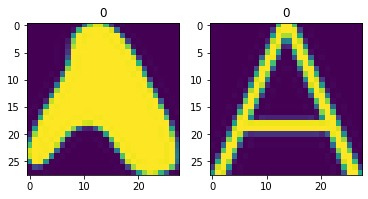

In [25]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [26]:
train_loader = DataLoader(
    full_dataset, batch_size=8, shuffle=True)

We can use dataloader as iterator by using iter() function.

In [27]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [29]:
images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/artem/Documents/ML_projets/venvs/work_env/lib/python3.8/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


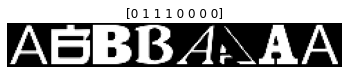

In [30]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

And now with transformations:

In [31]:
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [32]:
img, lab = train_dataset_with_transform.__getitem__(0)

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [33]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = train_iter_tr.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


In [ ]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [34]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [35]:
a = Flatten()

In [36]:
a(img).shape

torch.Size([784])

In [38]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

# Putting all together

In [39]:
import time

from IPython.display import clear_output

In [40]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [41]:
def subset_ind(dataset, ratio: float):
#     return ### YOUR CODE HERE 
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [42]:
# Note: create new dataset using indexes from subset_ind
dataset = DatasetMNIST(
    './notMNIST_small',
#     'AB',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [47]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(
    dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)
 
print(f'training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')
print(f'\nType of train_dataset:\n{type(train_dataset)}')

training size: 2996
validation size: 748

Type of train_dataset:
<class 'torch.utils.data.dataset.Subset'>


In [53]:
batch_size = 32

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True)

In [141]:
for X_, y_ in train_loader: 
    print(X_,'\n'*3, y_)
    break

tensor([[-0.9275, -0.9275, -0.9275,  ..., -0.9275, -0.9275, -0.9275],
        [-0.9275, -0.9275, -0.9275,  ..., -0.9275, -0.9275, -0.9275],
        [-0.9275, -0.9275, -0.9275,  ..., -0.9275, -0.9275, -0.9275],
        ...,
        [-0.9275, -0.9275, -0.9275,  ..., -0.9275, -0.9275, -0.9275],
        [-0.9275, -0.9275, -0.9275,  ..., -0.9275, -0.9275, -0.9275],
        [-0.9275, -0.9275, -0.9104,  ..., -0.9104, -0.9275, -0.9275]]) 


 tensor([7, 9, 8, 2, 1, 3, 6, 3, 5, 5, 3, 1, 2, 3, 5, 8, 2, 1, 8, 7, 6, 6, 8, 3,
        1, 1, 0, 4, 6, 9, 9, 7])


In [54]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [62]:
# There is no parameters for training 
# Softmax is here 
loss_fn = nn.CrossEntropyLoss()

In [61]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
    #nn.Sigmoid(),
)
model.to(device, torch.float32)


# Note: opt is responsible for
# 1. computing gradients 
# 2. updates model with lr
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [58]:
from torchsummary import summary

In [60]:
summary(model,(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [89]:
# Note: important to drop grad from tensor
a = torch.ones(1).requires_grad_(True)
b = 2
a = b * a
a.backward()
print(a)
print(a.item())
del a,b

tensor([2.], grad_fn=<MulBackward0>)
2.0


In [172]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior + calc grads
        for X_batch, y_batch in train_loader:
            # move data to target device
            ### YOUR CODE HERE
             
            opt.zero_grad()
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            loss.backward()
            opt.step()            
            # Note: loss.item() - to get value without computation graph
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad(): # do not calculate grads
            for X_batch, y_batch in val_loader:
                # move data to target device
                ### YOUR CODE HERE
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                # compute predictions
                ### YOUR CODE HERE
                ep_val_loss.append(loss.item())### YOUR CODE HERE)
                y_pred = predictions.max(1)[1].data### YOUR CODE HERE
                ep_val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))### YOUR CODE HERE)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [174]:
n_epochs = 30

train_loss,  val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.102s
	  training loss: 0.247192
	validation loss: 0.482218
	validation accuracy: 0.876
Epoch 2 of 30 took 0.090s
	  training loss: 0.230714
	validation loss: 0.475443
	validation accuracy: 0.884
Epoch 3 of 30 took 0.094s
	  training loss: 0.218534
	validation loss: 0.476607
	validation accuracy: 0.882
Epoch 4 of 30 took 0.092s
	  training loss: 0.205442
	validation loss: 0.492550
	validation accuracy: 0.882
Epoch 5 of 30 took 0.081s
	  training loss: 0.197646
	validation loss: 0.509616
	validation accuracy: 0.875
Epoch 6 of 30 took 0.078s
	  training loss: 0.188642
	validation loss: 0.484192
	validation accuracy: 0.882
Epoch 7 of 30 took 0.112s
	  training loss: 0.179751
	validation loss: 0.500471
	validation accuracy: 0.886
Epoch 8 of 30 took 0.090s
	  training loss: 0.171224
	validation loss: 0.483020
	validation accuracy: 0.879
Epoch 9 of 30 took 0.098s
	  training loss: 0.160278
	validation loss: 0.495371
	validation accuracy: 0.879
Epoch 10 of 30 took 0.100s
	

In [175]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

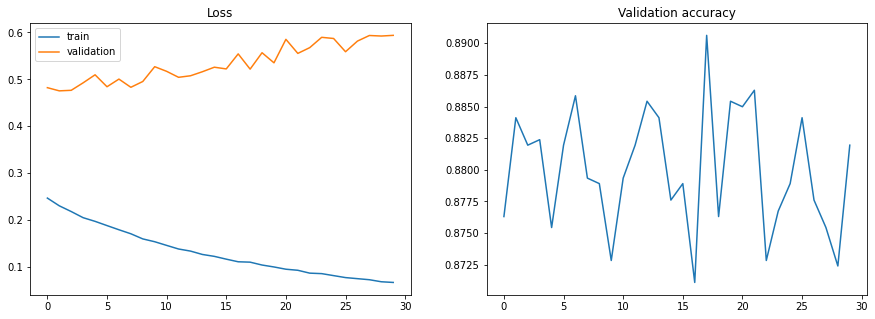

In [176]:
plot_train_process(train_loss, val_loss, val_accuracy)

Overfitting - small dataset and simple model

## Real network

In [184]:
# create network again just in case
# more complex model:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [185]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.380s
	  training loss: 0.607853
	validation loss: 0.448340
	validation accuracy: 0.862
Epoch 2 of 30 took 0.377s
	  training loss: 0.299604
	validation loss: 0.375512
	validation accuracy: 0.894
Epoch 3 of 30 took 0.402s
	  training loss: 0.201187
	validation loss: 0.438288
	validation accuracy: 0.898
Epoch 4 of 30 took 0.383s
	  training loss: 0.148770
	validation loss: 0.429105
	validation accuracy: 0.896
Epoch 5 of 30 took 0.440s
	  training loss: 0.093960
	validation loss: 0.478157
	validation accuracy: 0.878
Epoch 6 of 30 took 0.368s
	  training loss: 0.058232
	validation loss: 0.565608
	validation accuracy: 0.882
Epoch 7 of 30 took 0.417s
	  training loss: 0.057010
	validation loss: 0.580883
	validation accuracy: 0.889
Epoch 8 of 30 took 0.407s
	  training loss: 0.055522
	validation loss: 0.505767
	validation accuracy: 0.902
Epoch 9 of 30 took 0.377s
	  training loss: 0.035094
	validation loss: 0.617680
	validation accuracy: 0.888
Epoch 10 of 30 took 0.367s
	

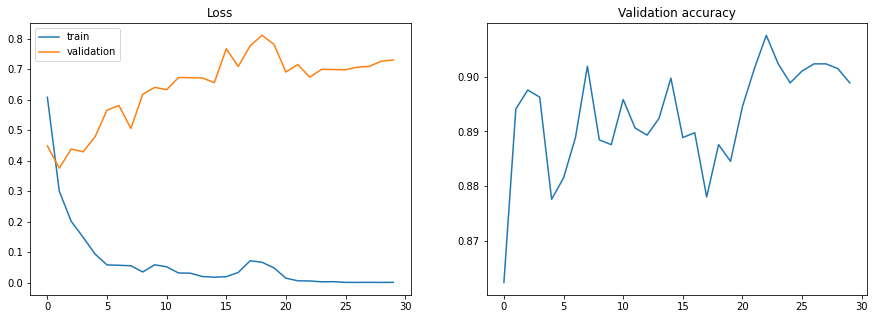

In [186]:
plot_train_process(train_loss, val_loss, val_accuracy)

Better, but we also have overfitting

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

### Dropout try

In [187]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 300),
    nn.ReLU(),  
    nn.Dropout(p=0.6),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.Linear(200, 10),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [188]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.315s
	  training loss: 1.088283
	validation loss: 0.465266
	validation accuracy: 0.865
Epoch 2 of 30 took 0.311s
	  training loss: 0.586601
	validation loss: 0.422363
	validation accuracy: 0.883
Epoch 3 of 30 took 0.344s
	  training loss: 0.483759
	validation loss: 0.413341
	validation accuracy: 0.879
Epoch 4 of 30 took 0.318s
	  training loss: 0.419978
	validation loss: 0.369251
	validation accuracy: 0.904
Epoch 5 of 30 took 0.330s
	  training loss: 0.386436
	validation loss: 0.373862
	validation accuracy: 0.898
Epoch 6 of 30 took 0.323s
	  training loss: 0.348896
	validation loss: 0.379693
	validation accuracy: 0.892
Epoch 7 of 30 took 0.303s
	  training loss: 0.350914
	validation loss: 0.391457
	validation accuracy: 0.887
Epoch 8 of 30 took 0.362s
	  training loss: 0.317826
	validation loss: 0.398364
	validation accuracy: 0.885
Epoch 9 of 30 took 0.317s
	  training loss: 0.302949
	validation loss: 0.372949
	validation accuracy: 0.903
Epoch 10 of 30 took 0.316s
	

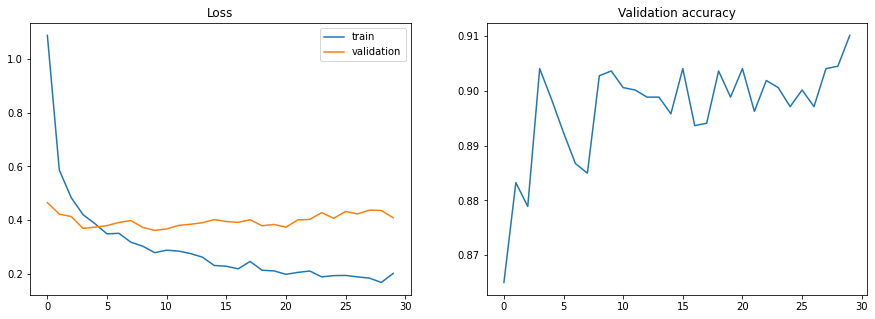

In [189]:
plot_train_process(train_loss, val_loss, val_accuracy)

### BatchNorm try

In [ ]:
# wr

In [279]:
model = nn.Sequential(
    nn.Linear(784, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 10),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [280]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.369s
	  training loss: 0.586193
	validation loss: 0.470105
	validation accuracy: 0.863
Epoch 2 of 30 took 0.357s
	  training loss: 0.343363
	validation loss: 0.410046
	validation accuracy: 0.878
Epoch 3 of 30 took 0.416s
	  training loss: 0.234790
	validation loss: 0.396225
	validation accuracy: 0.881
Epoch 4 of 30 took 0.375s
	  training loss: 0.179469
	validation loss: 0.370062
	validation accuracy: 0.897
Epoch 5 of 30 took 0.429s
	  training loss: 0.128565
	validation loss: 0.390764
	validation accuracy: 0.887
Epoch 6 of 30 took 0.370s
	  training loss: 0.097278
	validation loss: 0.472298
	validation accuracy: 0.872
Epoch 7 of 30 took 0.380s
	  training loss: 0.078939
	validation loss: 0.463212
	validation accuracy: 0.885
Epoch 8 of 30 took 0.409s
	  training loss: 0.075158
	validation loss: 0.412868
	validation accuracy: 0.906
Epoch 9 of 30 took 0.470s
	  training loss: 0.064004
	validation loss: 0.549024
	validation accuracy: 0.889
Epoch 10 of 30 took 0.504s
	

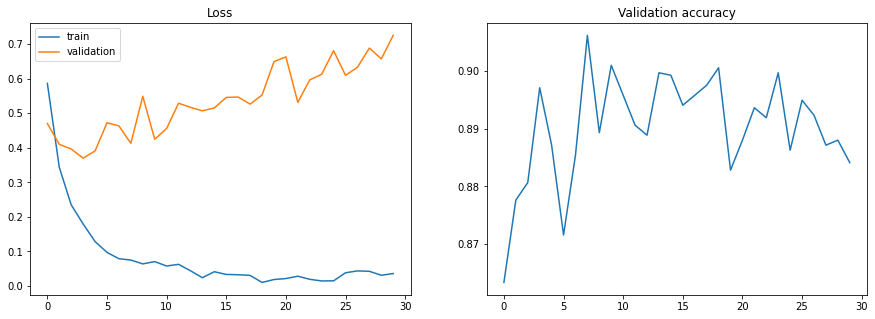

In [281]:
plot_train_process(train_loss, val_loss, val_accuracy)

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [282]:
torch.save(
    model.state_dict(),
    'trained_model.pth'
)

In [283]:
model2 = nn.Sequential(
    nn.Linear(784, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 10),
) 

print(summary(model2, (784,)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]         235,500
              ReLU-2                  [-1, 300]               0
       BatchNorm1d-3                  [-1, 300]             600
            Linear-4                  [-1, 200]          60,200
              ReLU-5                  [-1, 200]               0
       BatchNorm1d-6                  [-1, 200]             400
            Linear-7                   [-1, 10]           2,010
Total params: 298,710
Trainable params: 298,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.14
Estimated Total Size (MB): 1.15
----------------------------------------------------------------
None


In [284]:
print(torch.allclose(
    model.eval()(example_batch),
    model2(example_batch)
))

print('Load saved model')

model2.load_state_dict(
    torch.load('trained_model.pth')
)

False
Load saved model


<All keys matched successfully>

In [285]:
# Note: important to turn loaded model to eval mode
model2.eval()

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=300, out_features=200, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=200, out_features=10, bias=True)
)

In [286]:
print(torch.allclose(
    model(example_batch),
    model2(example_batch), 
    rtol = 1e-3
))

True


In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Testing -- you should get a pretty poor performance since the model hasn't learned anything yet.
test()

#### Define a training loop with model checkpointing

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [ ]:
train_save(5, save_interval=500, log_interval=100)

In [ ]:
!ls mnist*.pth

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('<CHECKPOINT NAME>', model, optimizer)
# should give you the final model accuracy
test()

```

```

```

```

```

```

```

```

```

```
### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)